In [1]:
import numpy as np
import pandas as pd
import os, glob, re
import matplotlib.pyplot as plt
import imageio
import scipy.ndimage.morphology as scipy_morph
import skimage.morphology as skimg_morph

np.random.seed(42)

In [2]:
tissue_load_dir = './Training Data/Y_tissue/' # .h5
xml2binary_load_dir = './Training Data/Y_xml2binary/' # .npy

tissue_fns = sorted(glob.glob(tissue_load_dir + '*.h5') + glob.glob(tissue_load_dir + '*.H5'))
xml2binary_fns = sorted(glob.glob(xml2binary_load_dir + '*.npy') + glob.glob(tissue_load_dir + '*.NPY'))

In [3]:
Y_save_dir = './Training Data/Y_l2/'
os.makedirs(Y_save_dir, exist_ok=True)

PID_save_dir = './Training Data/PID/'
os.makedirs(PID_save_dir, exist_ok=True)

PID_fig_save_dir = './Training Data/PID_fig/'
os.makedirs(PID_fig_save_dir, exist_ok=True)

In [5]:
for i, (tissue_fn, xml2binary_fn) in enumerate(zip(tissue_fns, xml2binary_fns)):
    df = pd.read_hdf(tissue_fn, key='/levle 2')
    tissue = df.values > 0
    xml2binary = np.load(xml2binary_fn)
    assert tissue.shape == xml2binary.shape
    tumor = tissue * xml2binary
    np.save(Y_save_dir + 'tumor_mask_' + str(i+1) + '.npy', tumor)
    
    # remove blobs
    tumor = skimg_morph.remove_small_objects(tumor, min_size=256*256, connectivity=1, in_place=False)
    tissue = skimg_morph.remove_small_objects(tissue, min_size=256*256, connectivity=1, in_place=False)
    
    # exclude marginal pixels
    pad_mask = np.ones((tissue.shape[0]-20, tissue.shape[1]-20), dtype=np.uint8)
    pad_mask = np.pad(pad_mask, ((10,10),(10,10)), mode='constant')
    tumor = tumor * pad_mask > 0
    tissue = tissue * pad_mask > 0
    
    # get border between the tumor and the non-tumor tissue
    ntt = tissue * np.invert(tumor)
    dil = scipy_morph.binary_dilation(tumor)
    tumor_edge = dil * np.invert(tumor)
    border = tumor_edge * ntt
    
    # sample indices
    class_list = [tumor, ntt, border]
    result = []
    for c in class_list:
        c_ids = np.argwhere(c)
        loc = np.random.choice(len(c_ids), 500, replace=False)
        c_sample_ids = c_ids[loc]
        result.append(c_sample_ids)
        
    # save sampled indices (of level 0)
    result_npy = np.concatenate(result)
    pd.DataFrame(result_npy * 16).to_csv(PID_save_dir + 'PID_' + str(i+1) + '.csv')
        
    # save plotted imgs of sampled indices
    plt.figure()
    x, y = result[0].T
    plt.axis([0,tissue.shape[1],tissue.shape[0],0])
    plt.scatter(y, x, c='r')
    x, y = result[1].T
    plt.scatter(y, x, c='g')
    x, y = result[2].T
    plt.scatter(y, x, c='b')
    plt.savefig(PID_fig_save_dir + 'PID_fig_' + str(i+1) + '.png')
    plt.close()

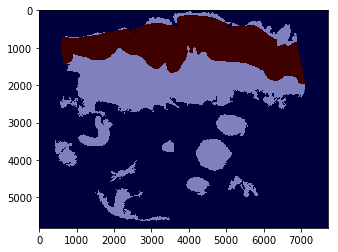

In [6]:
plt.imshow(ntt, cmap='gray')
plt.imshow(tumor, cmap='jet', alpha=0.5)